# Testing dynamicME on the latest cobrame model

In [1]:
CONSTRAIN_O2 = True
TUNE_GLPK = True     # GLPK for glycerol
TUNE_RESPIRATION = True

TUNE_MALTOSE = False  # maltose ABC transporter
TUNE_GAL     = False
TUNE_FERMENT = False
TUNE_LACTATE = False  # rph-pyrE

In [2]:
from dynamicme.dynamic import DynamicME

## 1. Build the ME model anew
### Only need to run this once or if a new version of the ME model is released

In [3]:
# %run /source/ecolime/ecolime/build_me_model.py

## 2. Load the built ME model

In [77]:
from cobrame.io.json import load_reduced_json_me_model, load_json_me_model
import pickle

In [80]:
with open('/source/ecolime/ecolime/me_models/iJL1678b.pickle','rb') as f:
    me = pickle.load(f)

In [81]:
rxn = me.reactions.get_by_id('GLYCtpp_REV_SPONT')
rxn.lower_bound = 0
rxn.upper_bound = 0

# 3. Set up the dynamic simulation

## Here, we will simulate the complex medium originally investigated by [Beg et al., 2007](http://www.pnas.org/content/104/31/12663)

### Metabolites to track

In [7]:
tracked_mets = [
    me.metabolites.ac_p,
    me.metabolites.gal_p,
    me.metabolites.glc__D_p,
    me.metabolites.glyc_p,
    me.metabolites.lac__L_p, 
    me.metabolites.malt_p
    ]
extra_rxns_tracked = [me.reactions.biomass_dilution, me.reactions.EX_o2_e]

### Also track translation fluxes

In [8]:
rxns_trsl = me.reactions.query('translation_')
print len(rxns_trsl)
extra_rxns_tracked = extra_rxns_tracked + rxns_trsl

from minime.core.MEReactions import MetabolicReaction
import pandas as pd

rows_tracked = []

for met_track in tracked_mets:
    mid_c = met_track.id.replace('_p','_c')
    mid_e = met_track.id.replace('_p','_e')
    met_c = me.metabolites.get_by_id(mid_c)
    met_e = me.metabolites.get_by_id(mid_e)
    for rxn in met_track.reactions:
        if isinstance(rxn, MetabolicReaction) and rxn.keff and met_c in rxn.metabolites or met_e in rxn.metabolites:
            extra_rxns_tracked.append(rxn)
            rows_tracked.append({'met':met_track.id, 'rxn':rxn.id})
            #print met_track,'\t', rxn.id, '\t', rxn.keff          
            
df_tracked = pd.DataFrame(rows_tracked)

1569


In [9]:
dyme = DynamicME(me)

T = 10   # hours
V = 1.   # L
X0 = 0.00675 / V  # g/L
c0_dict = {'glc__D_e': 0.4,
           'lac__L_e': 0.4,
           'malt_e': 0.4,
           'gal_e': 0.4,
           'glyc_e':0.4,
           'ac_e': 0.0}
### Convert from g/L to mmol
for mid,c in c0_dict.iteritems():
    met = me.metabolites.get_by_id(mid)
    c0_dict[met.id] = c / met.formula_weight * 1000

### Set max uptake rate
LB_EX = -10.
LB_O2 = -20.

lb_dict={}
ub_dict={}

for mid in c0_dict.keys():    
    rxn = dyme.get_exchange_rxn(mid)    
    if rxn.id is 'EX_o2_e':
        lb = LB_O2
    else:
        lb = LB_EX
    #rxn.lower_bound = lb
    lb_dict[rxn.id] = lb

#me.reactions.EX_o2_e.lower_bound = LB_O2
lb_dict[me.reactions.EX_o2_e.id] = LB_O2

print c0_dict
print lb_dict
print ub_dict

sim_params = {
    'T':T,
    'X0':X0,
    'c0_dict':c0_dict,
    'lb_dict':lb_dict,
    'ub_dict':ub_dict,
    'extra_rxns_tracked':extra_rxns_tracked,
    'ZERO_CONC':0.
}

{'glyc_e': 4.34339676647141, 'malt_e': 1.1685776026677226, 'lac__L_e': 4.4908498933423155, 'gal_e': 2.220299442904667, 'ac_e': 0.0, 'glc__D_e': 2.220299442904667}
{u'EX_glyc_e': -10.0, u'EX_o2_e': -20.0, u'EX_gal_e': -10.0, u'EX_lac__L_e': -10.0, u'EX_malt_e': -10.0, u'EX_ac_e': -10.0, 'EX_glc__D_e': -10.0}
{}


# 4. Some manual keff tuning from literature (see Methods)

In [10]:
growth_rxn = me.reactions.biomass_dilution
df_pert = df_tracked
groups = df_pert['met'].unique()

pert_rxns = [r for r in df_pert['rxn'].values]

group_rxn_dict = {met:df_pert[ df_pert['met']==met]['rxn'].values.tolist() for met in groups}
print group_rxn_dict['malt_p']
print group_rxn_dict['glyc_p']

[u'MALTtexi_FWD_CPLX0-7655']
[u'GLYCtex_FWD_CPLX0-7530', u'GLYCtex_FWD_CPLX0-7533', u'GLYCtex_FWD_G6700-MONOMER', u'GLYCtex_REV_G6700-MONOMER', u'GLYCtex_REV_CPLX0-7534', u'GLYCtex_REV_CPLX0-7530', u'GLYCtex_REV_CPLX0-7533', u'GLYCtex_FWD_CPLX0-7534']


In [11]:
rows_perturb_manual = []

### Maltose

In [12]:
### ABC-16-CPLX: malEGFK
# vmax = 500 - 1000 nmol/min/mg
#      = 30 - 60 mmol/h/g

#for rid in group_rxn_dict['malt_p']:
for rid in ['MALTabcpp_FWD_ABC-16-CPLX']:
    rxn = me.reactions.get_by_id(rid)
    extra_rxns_tracked.append(rxn)

    rows_perturb_manual.append({'met':'malt_p', 'rxn':rxn.id})
    
    if TUNE_MALTOSE:
        keff1 = rxn.keff
        keff2 = keff1*0.5
        print 'Changing keff for %s from %g to %g'%(rxn.id, keff1, keff2)
        rxn.keff = keff2
        rxn.update()
        print rxn.id, ':\t', rxn.reaction


### Galactose

In [13]:
# The p -> c transporters
met_c = me.metabolites.gal_c
for rxn in me.metabolites.gal_p.reactions:    
    if met_c in rxn.metabolites.keys():        
        print rxn.id, ':\t', rxn.reaction
        extra_rxns_tracked.append(rxn)    
        rows_perturb_manual.append({'met':'gal_p', 'rxn':rxn.id})
    
        if TUNE_GAL:
            keff1 = rxn.keff
            keff2 = keff1*0.5
            print 'Changing keff for %s from %g to %g'%(rxn.id, keff1, keff2)
            rxn.keff = keff2
            rxn.update()
            print rxn.id, ':\t', rxn.reaction

GALabcpp_FWD_ABC-18-CPLX :	2.3152762057411e-6*mu ABC-18-CPLX + atp_c + gal_p + h2o_c --> adp_c + gal_c + h_c + pi_c
GALt2pp_FWD_GALP-MONOMER :	6.92241552501064e-6*mu GALP-MONOMER + gal_p + h_p --> gal_c + h_c
GALabcpp_FWD_ABC-46-CPLX :	2.52518632247802e-6*mu ABC-46-CPLX + atp_c + gal_p + h2o_c --> adp_c + gal_c + h_c + pi_c


### Glycerol

### Glycerol kinase (GLPK) known to be rate-limiting (Applebee et al., 2011)

In [14]:
### From Applebee et al. (2011)
vmax_glpk_ale = 86
vmax_glpk_wt  = 18.1

for rxn in me.process_data.GLYK.parent_reactions:
    extra_rxns_tracked.append(rxn)
    rows_perturb_manual.append({'met':'glyc_p', 'rxn':rxn.id})
    if TUNE_GLPK:
        keff1 = rxn.keff
        keff2 = keff1 * vmax_glpk_wt / vmax_glpk_ale
        print 'Changing keff for %s from %g to %g'%(rxn.id, keff1, keff2)
        rxn.keff = keff2
        rxn.update()
        print rxn.id, ':\t', rxn.reaction    

Changing keff for GLYK_FWD_GLYCEROL-KIN-CPLX_mod_mn2 from 122.117 to 25.7013
GLYK_FWD_GLYCEROL-KIN-CPLX_mod_mn2 :	1.08079063567606e-5*mu GLYCEROL-KIN-CPLX_mod_mn2 + atp_c + glyc_c --> adp_c + glyc3p_c + h_c
Changing keff for GLYK_FWD_GLYCEROL-KIN-CPLX_mod_mg2 from 122.117 to 25.7013
GLYK_FWD_GLYCEROL-KIN-CPLX_mod_mg2 :	1.08079063567606e-5*mu GLYCEROL-KIN-CPLX_mod_mg2 + atp_c + glyc_c --> adp_c + glyc3p_c + h_c


In [15]:
### Enzymes whose activity increased considerably in endpoints
# Hua et al., (2007) AEM
## Lactate utilization
# lldD: L__LACD2, L__LACD3
# lldP (b3603): L__LACt2rpp
## 
# PPS: induced in all 7 endpoints
# pck
# ppc
# gltA
# sucB


### lldD
for rxn in me.process_data.L__LACD2.parent_reactions:
    extra_rxns_tracked.append(rxn)
    rows_perturb_manual.append({'met':'lac__L_p', 'rxn':rxn.id})
    if TUNE_LACTATE:
        keff1 = rxn.keff
        keff2 = keff1 / 2.   # Unknown: so arbitrarily set to half
        print 'Changing keff for %s from %g to %g'%(rxn.id, keff1, keff2)
        rxn.keff = keff2
        rxn.update()
        print rxn.id, ':\t', rxn.reaction
    
for rxn in me.process_data.L__LACD3.parent_reactions:
    extra_rxns_tracked.append(rxn)
    rows_perturb_manual.append({'met':'lac__L_p', 'rxn':rxn.id})
    if TUNE_LACTATE:
        keff1 = rxn.keff
        keff2 = keff1 / 2.   # Unknown: so arbitrarily set to half
        print 'Changing keff for %s from %g to %g'%(rxn.id, keff1, keff2)
        rxn.keff = keff2
        rxn.update()
        print rxn.id, ':\t', rxn.reaction

### lldP
for rxn in me.process_data.L__LACt2rpp.parent_reactions:
    extra_rxns_tracked.append(rxn)
    rows_perturb_manual.append({'met':'lac__L_p', 'rxn':rxn.id})
    if TUNE_LACTATE:
        keff1 = rxn.keff
        keff2 = keff1 / 2.   # Unknown: so arbitrarily set to half
        print 'Changing keff for %s from %g to %g'%(rxn.id, keff1, keff2)
        rxn.keff = keff2
        rxn.update()
        print rxn.id, ':\t', rxn.reaction

### PPS
for rxn in me.process_data.PPS.parent_reactions:
    extra_rxns_tracked.append(rxn)
    rows_perturb_manual.append({'met':'lac__L_p', 'rxn':rxn.id})
    if TUNE_LACTATE:
        keff1 = rxn.keff
        keff2 = keff1 / 1.5   # Hua et al. observed 1.5-fold induction of pps expression
        print 'Changing keff for %s from %g to %g'%(rxn.id, keff1, keff2)
        rxn.keff = keff2
        rxn.update()
        print rxn.id, ':\t', rxn.reaction

### PCK
for rxn in me.process_data.PPCK.parent_reactions:
    extra_rxns_tracked.append(rxn)
    rows_perturb_manual.append({'met':'lac__L_p', 'rxn':rxn.id})
    if TUNE_LACTATE:
        keff1 = rxn.keff
        keff2 = keff1 * 6. / (6+11-7-1)
        print 'Changing keff for %s from %g to %g'%(rxn.id, keff1, keff2)
        rxn.keff = keff2
        rxn.update()
        print rxn.id, ':\t', rxn.reaction

for rxn in me.process_data.PPC.parent_reactions:
    extra_rxns_tracked.append(rxn)
    rows_perturb_manual.append({'met':'lac__L_p', 'rxn':rxn.id})
    if TUNE_LACTATE:
        keff1 = rxn.keff
        keff2 = keff1 * 14. / (14+9-6+6)
        print 'Changing keff for %s from %g to %g'%(rxn.id, keff1, keff2)
        rxn.keff = keff2
        rxn.update()
        print rxn.id, ':\t', rxn.reaction

for rxn in me.process_data.CS.parent_reactions:
    extra_rxns_tracked.append(rxn)
    rows_perturb_manual.append({'met':'lac__L_p', 'rxn':rxn.id})
    if TUNE_LACTATE:
        keff1 = rxn.keff
        keff2 = keff1 * 22. / (22+4+10-6)
        print 'Changing keff for %s from %g to %g'%(rxn.id, keff1, keff2)
        rxn.keff = keff2
        rxn.update()
        print rxn.id, ':\t', rxn.reaction

### Respiration
Basan et al. (2015) Nat: proteome cost of energy biogenesis by respiration exceeds that by fermentation
- TCA
- Cytochromes
- ATP synthase

In [16]:
### Isocitrate dehyrogenase keffs were way too high
for rxn in me.process_data.ICDHyr.parent_reactions:
    extra_rxns_tracked.append(rxn)
    rows_perturb_manual.append({'met':'o2_e', 'rxn':rxn.id})
    if TUNE_RESPIRATION:
        keff1 = rxn.keff
        keff2 = 11900./60   # BIONUMBERS http://bionumbers.hms.harvard.edu/bionumber.aspx?id=101152
        # 106.4    ### BRENDA for 40oC
        if keff2 < keff1:
            print 'Changing keff for %s from %g to %g'%(rxn.id, keff1, keff2)
            rxn.keff = keff2
            rxn.update()
            print rxn.id, ':\t', rxn.reaction

### ATP Synthase: 
# F0F1: 270 +/- 40 s-1: http://www.ncbi.nlm.nih.gov/pubmed/9030757

### Cytochromes
# Zhuang (2011)
# Cyd-II: low cost
# Cyo: costly
# Cyd-I: preferred in microaerobic
# Cytochrome oxidase bo3 (ubiquinol-8: 4 protons)
for rxn in me.process_data.CYTBO3_4pp.parent_reactions:
    extra_rxns_tracked.append(rxn)
    rows_perturb_manual.append({'met':'o2_e', 'rxn':rxn.id})
    if TUNE_RESPIRATION:
        keff1 = rxn.keff
        keff2 = 300. # http://www.brenda-enzymes.org/enzyme.php?ecno=1.9.3.1
        if keff2 < keff1:
            print 'Changing keff for %s from %g to %g'%(rxn.id, keff1, keff2)
            rxn.keff = keff2
            rxn.update()
            print rxn.id, ':\t', rxn.reaction
            
# Cytochrome oxidase bd (menaquinol-8: 2 protons)
for rxn in me.process_data.CYTBD2pp.parent_reactions:
    extra_rxns_tracked.append(rxn)
    rows_perturb_manual.append({'met':'o2_e', 'rxn':rxn.id})
    if TUNE_RESPIRATION:
        keff1 = rxn.keff
        keff2 = keff1 / 2.
        if keff2 < keff1:
            print 'Changing keff for %s from %g to %g'%(rxn.id, keff1, keff2)
            rxn.keff = keff2
            rxn.update()
            print rxn.id, ':\t', rxn.reaction
            
# Cytochrome oxidase bd (ubiquinol-8: 2 protons)
for rxn in me.process_data.CYTBDpp.parent_reactions:
    extra_rxns_tracked.append(rxn)
    rows_perturb_manual.append({'met':'o2_e', 'rxn':rxn.id})
    if TUNE_RESPIRATION:
        keff1 = rxn.keff
        keff2 = keff1 / 2.
        if keff2 < keff1:
            print 'Changing keff for %s from %g to %g'%(rxn.id, keff1, keff2)
            rxn.keff = keff2
            rxn.update()
            print rxn.id, ':\t', rxn.reaction

Changing keff for ICDHyr_FWD_ISOCITHASE-CPLX_mod_mn2 from 3000 to 198.333
ICDHyr_FWD_ISOCITHASE-CPLX_mod_mn2 :	1.40056022408964e-6*mu ISOCITHASE-CPLX_mod_mn2 + icit_c + nadp_c --> akg_c + co2_c + nadph_c
Changing keff for ICDHyr_FWD_ISOCITHASE-CPLX_mod_mg2 from 3000 to 198.333
ICDHyr_FWD_ISOCITHASE-CPLX_mod_mg2 :	1.40056022408964e-6*mu ISOCITHASE-CPLX_mod_mg2 + icit_c + nadp_c --> akg_c + co2_c + nadph_c
Changing keff for CYTBO3_4pp_FWD_CYT-O-UBIOX-CPLX_mod_pheme_mod_hemeO_mod_cu2 from 3000 to 300
CYTBO3_4pp_FWD_CYT-O-UBIOX-CPLX_mod_pheme_mod_hemeO_mod_cu2 :	9.25925925925926e-7*mu CYT-O-UBIOX-CPLX_mod_pheme_mod_hemeO_mod_cu2 + 4.0 h_c + 0.5 o2_c + q8h2_c --> h2o_c + 4.0 h_p + q8_c
Changing keff for CYTBD2pp_FWD_APP-UBIOX-CPLX_mod_pheme_mod_hemed from 66.6717 to 33.3358
CYTBD2pp_FWD_APP-UBIOX-CPLX_mod_pheme_mod_hemed :	8.33270537899445e-6*mu APP-UBIOX-CPLX_mod_pheme_mod_hemed + 2.0 h_c + mql8_c + 0.5 o2_c --> h2o_c + 2.0 h_p + mqn8_c
Changing keff for CYTBDpp_FWD_APP-UBIOX-CPLX_mod_phem

In [20]:
df_pert_manual = pd.DataFrame(rows_perturb_manual).drop_duplicates()
print df_pert_manual.shape

(94, 2)


In [21]:
# Append timestamp to filename
import time
timestr = '_'+time.strftime("%Y%m%d_%H%M")
print timestr

# Append simulation conditions to filename
simstr = ''
if TUNE_GLPK: simstr = simstr + '_GLPK'
if TUNE_LACTATE: simstr = simstr + '_LAC'
if TUNE_MALTOSE: simstr = simstr + '_MALT'
if TUNE_RESPIRATION: simstr = simstr + '_RESP'
if TUNE_FERMENT: simstr = simstr + '_FERM'

print simstr

_20180529_1518
_GLPK_RESP


# 5. Perform DynamicME simulation

In [30]:
dyme = DynamicME(me)

In [31]:
import time

tic = time.time()

if CONSTRAIN_O2:
    result = dyme.simulate_batch(T, c0_dict, X0, prec_bs=1e-3, ZERO_CONC=0., extra_rxns_tracked=extra_rxns_tracked,
                             no_nlp=True, lb_dict={'EX_o2_e': -18.5}, verbosity=1)
else:
    result = dyme.simulate_batch(T, c0_dict, X0, prec_bs=1e-3, ZERO_CONC=0., extra_rxns_tracked=extra_rxns_tracked,
                             no_nlp=True, lb_dict={}, verbosity=1)
    
toc = time.time()-tic

Metabolite glyc_e available.
Using default LB=-1000 for EX_glyc_e
Metabolite ac_e depleted.
Metabolite lac__L_e available.
Using default LB=-1000 for EX_lac__L_e
Metabolite malt_e available.
Using default LB=-1000 for EX_malt_e
Metabolite gal_e available.
Using default LB=-1000 for EX_gal_e
Metabolite glc__D_e available.
Using default LB=-1000 for EX_glc__D_e
Computing new uptake rates
Finished compiling expressions in 61.803543 seconds
Finished substituting S,lb,ub in 2.566910 seconds
Finished makeME_LP in 0.446406 seconds
Getting MINOS parameters from ME_NLP...
Finished substituting S,lb,ub in 2.468678 seconds
Finished makeME_LP in 0.435880 seconds
Getting MINOS parameters from ME_NLP...
Finished substituting S,lb,ub in 2.455512 seconds
Finished makeME_LP in 0.437400 seconds
Getting MINOS parameters from ME_NLP...
Finished substituting S,lb,ub in 2.505133 seconds
Finished makeME_LP in 0.437377 seconds
Getting MINOS parameters from ME_NLP...
Finished substituting S,lb,ub in 2.464562 s

In [32]:
print '%g seconds'%toc

1623.21 seconds


# 6. Convert solution's metabolite concentrations from mM to g/L

In [39]:
from dynamicme.dynamic import ParamOpt

popt = ParamOpt(me, sim_params, growth_rxn=growth_rxn.id)
sol = popt.compute_conc_profile(result)

In [73]:
df_mw = pd.DataFrame([{'id':m.id,'mass':m.mass if hasattr(m,'mass') else m.formula_weight,'name':m.name} for m in me.metabolites])

sol_gL = sol.copy()
variables = c0_dict.keys()

for col in sol.columns:
    if col in variables:
        c_mM = sol[col]
        mw = df_mw[ df_mw.id==col].mass.values[0]
        c_gL = c_mM * mw / 1000.
        sol_gL[col] = c_gL
        
df_ex = pd.DataFrame(result['ex_flux'])
#df_ex[ df_ex['EX_ac_e'] != 0]

# 7. Plot metabolite concentration profiles

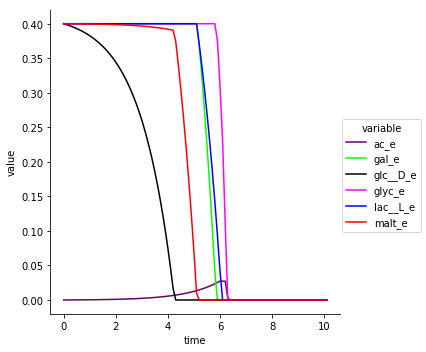

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

dsplot = sol_gL[[c for c in sol_gL.columns if c != 'biomass' and 'EX_' not in c]].melt(id_vars='time')

dsplot.variable.unique()

palette = ['#660066','#00FF00','#000000','#FF00FF','#0000FF','#FF0000']
sns.set_palette(palette)
g = sns.FacetGrid(dsplot, hue='variable', size=5)
g.map(plt.plot, 'time','value')
g.add_legend()